In [9]:
!gdown --id 1-6JTIDuocxNDkLjDxrN3BXrRLIv28txW

Downloading...
From: https://drive.google.com/uc?id=1-6JTIDuocxNDkLjDxrN3BXrRLIv28txW
To: /Users/nelkoncroos/Downloads/checkpoints.zip
272MB [01:09, 3.91MB/s] 


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import json
from PIL import Image

In [10]:
!unzip checkpoints.zip

Archive:  checkpoints.zip
   creating: image-caption/
   creating: image-caption/checkpoints/
   creating: image-caption/checkpoints/train/
  inflating: image-caption/checkpoints/train/ckpt-2.data-00000-of-00001  
  inflating: image-caption/checkpoints/train/ckpt-3.index  
  inflating: image-caption/checkpoints/train/ckpt-2.index  
  inflating: image-caption/checkpoints/train/ckpt-4.data-00000-of-00001  
  inflating: image-caption/checkpoints/train/checkpoint  
  inflating: image-caption/checkpoints/train/ckpt-1.data-00000-of-00001  
  inflating: image-caption/checkpoints/train/ckpt-4.index  
  inflating: image-caption/checkpoints/train/ckpt-3.data-00000-of-00001  
  inflating: image-caption/checkpoints/train/ckpt-1.index  
  inflating: image-caption/tokenizer.pickle  


In [11]:
!mv image-caption/checkpoints/ ./
!mv image-caption/tokenizer.pickle ./

In [12]:
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = inceptionv3.input
hidden_layer = inceptionv3.layers[-1].output
inception_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 20s 0us/step


In [13]:
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [15]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.f1 = tf.keras.layers.Dense(units)
        self.f2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_layer = tf.expand_dims(hidden, 1)
        attention = (tf.nn.tanh(self.f1(features) +
                                self.f2(hidden_layer)))
        score = self.V(attention)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [16]:
class Inception_Input(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Inception_Input, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = Attention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
embedding_dim = 256
units = 512
vocab_size = 5001
attention_features_shape = 64
max_length = 51

In [19]:
encoder = Inception_Input(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [20]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [21]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [22]:
checkpoint_path = "./checkpoints/train"
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [23]:
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [31]:
!ls

-astronaut-floating-space-wallpaper.jpg
123.jpeg
164072H_TakeHome Assignment.pdf
164166B - Assignment 1 (1).pdf
164166B - Assignment 1.pdf
164190R Assignment01 HCI.pdf
164190R Inclass1.pdf
164190R SAIT Takehome01.pdf
164190R SAIT.pdf
164190R SM.pdf
164190R inclass Assignment.pdf
164190R.jpeg
164190R.pdf
164200C (1).pdf
164200C.pdf
165010C.blend
165035G.pdf
184091H_IN2600_Practical_Exam_Part_01.zip
2020 _ 2021_Level 4_Semester 1_164190R_FullModule_RepeatForm.pdf
4.2. Contexts of Use_new.mkv
54501196_a9ac9d66f2.jpg
61O4kHG6WQL._RI_.jpg
AUDIO-2021-04-01-21-19-38.m4a
Academic Calendar2021_v02_0.pdf
Adobe_XD_v36.0.32__TNT_Torrentmac.net.dmg.torrent
Arturia
Atom.app
Black-Cool-2020-Best-HD-Wallpaper-48849.jpg
Case Study - Assignment 1.pdf
Coverletter.pdf
Database.pptx
Delivery report
Disk Inventory X 1.3.dmg
FoxitPhantomPDF411.L10N.Setup.pkg.download
FreeCoursesOnline.Me-Code-With-Mosh-The-Ultimate-Redux-Course.torrent
GitHub Desktop.app
GoogleService-Info.plist
HCI.pdf
Hostel arrival detail

/Users/nelkoncroos/.keras/datasets/image.jpg
Prediction Caption: two people play with two women play wii together <end>


<ipython-input-21-81c52a4eee3c>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


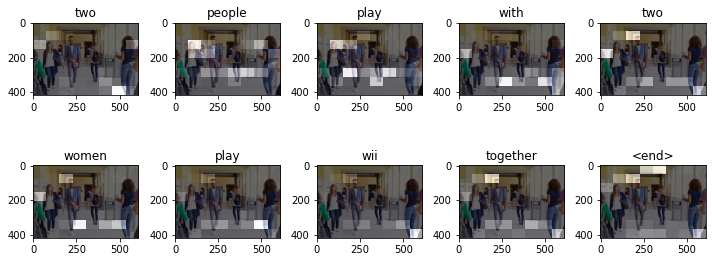

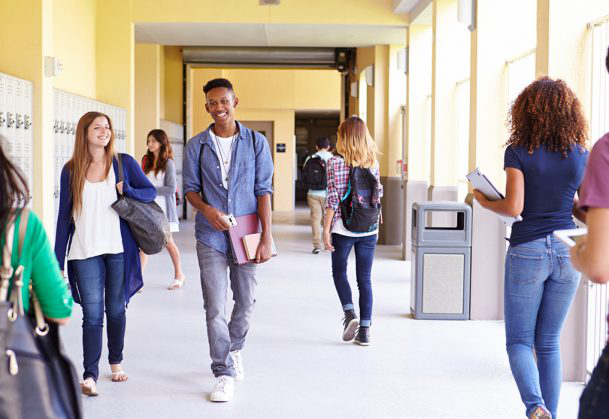

In [32]:
image_url = 'https://cdn.shopify.com/s/files/1/0982/6154/products/ComputerDeskTableK555-03_grande_2x.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
image_path = "123.jpeg"
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
Image.open(image_path)